In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for alpha in [[1, 3, 4], [1, 1, 1], [10, 0.2, 0.2], [0.1, 0.1, 0.1]]:
    theta = stats.dirichlet(alpha).rvs(500)

    fig = plt.figure(figsize=(8, 8), dpi=150)
    ax = plt.gca(projection='3d')
    plt.title(r'$\alpha$ = {}'.format(alpha))
    ax.scatter(theta[:, 0], theta[:, 1], theta[:, 2])
    ax.view_init(azim=30)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel(r'$\theta_3$')
    plt.show()

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
from scipy import stats
import tensorflow as tf
import edward as ed

/opt/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
df = pd.DataFrame(load_iris()['data'])

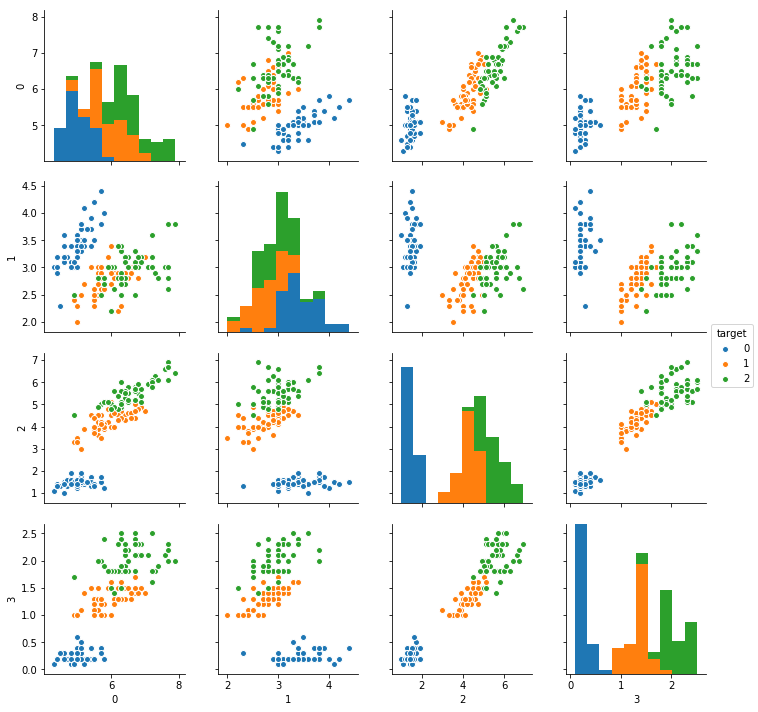

In [4]:
df['target'] = load_iris()['target']
sns.pairplot(df, hue='target', vars=[0, 1, 2, 3])

(array([ 4.,  1.,  6.,  5., 12.,  8.,  4.,  5.,  2.,  3.]),
 array([4.3 , 4.45, 4.6 , 4.75, 4.9 , 5.05, 5.2 , 5.35, 5.5 , 5.65, 5.8 ]),
 <a list of 10 Patch objects>)

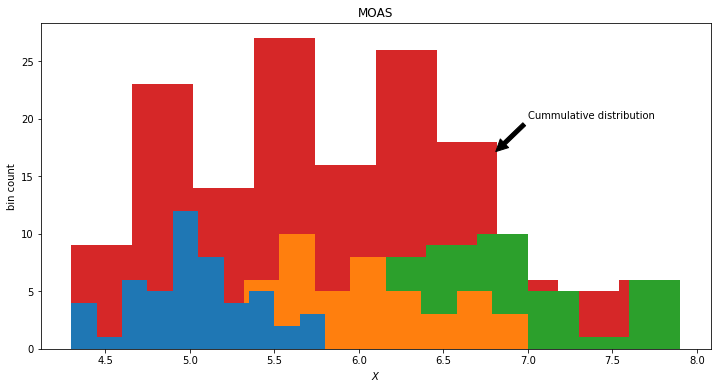

In [5]:
plt.figure(figsize=(12, 6))
b = 8
a = 4

plt.title('MOAS')
plt.xlabel(r'$X$')
plt.ylabel('bin count')
plt.annotate('Cummulative distribution', (6.8, 17), (7, 20), arrowprops=dict(facecolor='black', shrink=0.05))
plt.hist(df[0], color=sns.color_palette()[3], rwidth=a)
plt.hist(df[0][df['target'] == 2], color=sns.color_palette()[2], rwidth=a)
plt.hist(df[0][df['target'] == 1], color=sns.color_palette()[1], rwidth=a)
plt.hist(df[0][df['target'] == 0], color=sns.color_palette()[0], rwidth=a)


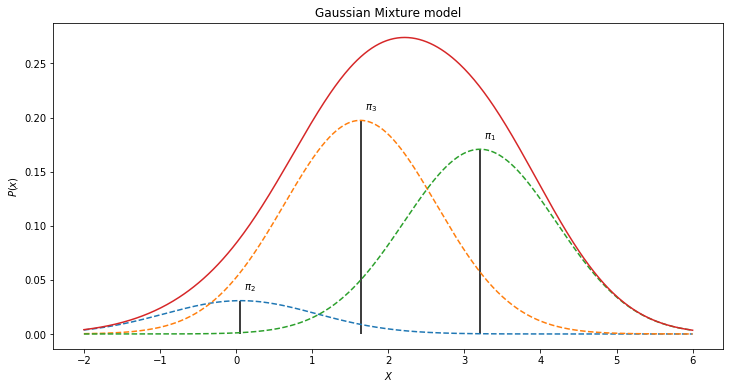

In [6]:
np.random.seed(13)
x = np.linspace(-2, 6, 500)
pi = stats.dirichlet([1, 1, 1]).rvs()[0]
mu = stats.norm(1, 1).rvs(3)

y = stats.norm(mu, np.ones(3)).pdf(x[:, None])
plt.figure(figsize=(12, 6))
plt.title('Gaussian Mixture model')
plt.ylabel(r'$P(x)$')
plt.xlabel(r'$X$')

plt.plot(x, y[:, 1] * pi[1], ls='--')
plt.plot(x, y[:, 2] * pi[2], ls='--')
plt.plot(x, y[:, 0] * pi[0], ls='--')

for i in range(3):
    xi = x[np.argmax(y[:, i])]
    yi = (y[:, i] * pi[i]).max()
    plt.vlines(xi, 0, yi)
    plt.text(xi + 0.05, yi + 0.01, r'$\pi_{}$'.format(i + 1))
plt.plot(x, (y * pi).sum(1))


In [3]:
df = pd.DataFrame(load_iris()['data'])
y = df.values
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [8]:
k = 3 # number of clusters

d = df.shape[1]
n = df.shape[0]

pi = ed.models.Dirichlet(tf.ones(k))
mu = ed.models.Normal(tf.zeros(d), tf.ones(d), sample_shape=k)  # shape (3, 4) 3 gaussians, 4 variates
sigmasq = ed.models.InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x = ed.models.ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 ed.models.MultivariateNormalDiag,
                 sample_shape=n)
z = x.cat

In [10]:
t = 500  # number of samples

qpi = ed.models.Empirical(tf.get_variable('qpi', shape=[t, k], initializer=tf.constant_initializer(1 / k)))
qmu = ed.models.Empirical(tf.get_variable('qmu', shape=[t, k, d], initializer=tf.zeros_initializer()))
qsigmasq = ed.models.Empirical(tf.get_variable('qsigmasq', shape=[t, k, d], initializer=tf.ones_initializer()))
qz = ed.models.Empirical(tf.get_variable('qz', shape=[t, n], initializer=tf.zeros_initializer(), dtype=tf.int32))     

In [11]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, 
                    data={x: y})
inference.run()

/opt/miniconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 1.000


In [64]:
mu_s = qmu.sample(500).eval()
sigmasq_s = qsigmasq.sample(500).eval()
pi_s = qpi.sample(500).eval()

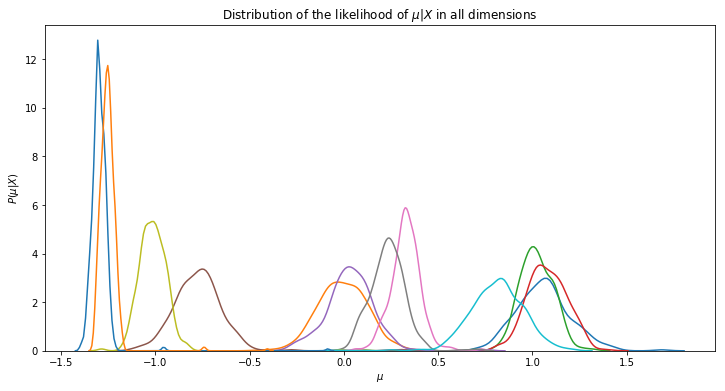

In [111]:
plt.figure(figsize=(12, 6))
plt.title(r'Distribution of the likelihood of $\mu | X$ in all dimensions')
plt.ylabel(r'$P(\mu|X)$')
plt.xlabel(r'$\mu$')
for i in range(3):
    for j in range(4):
        sns.distplot(mu_s[:, i, j], hist=False)

In [108]:
np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
           for i in range(3)]).argmax(axis=0)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [104]:
np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
          for i in range(3)])[::-1].argmax(axis=0).sum() / df.shape[0]

0.94

<BarContainer object of 3 artists>

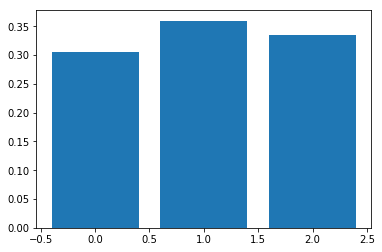

In [114]:
plt.bar(np.arange(pi_s.shape[1]), pi_s.mean(0))

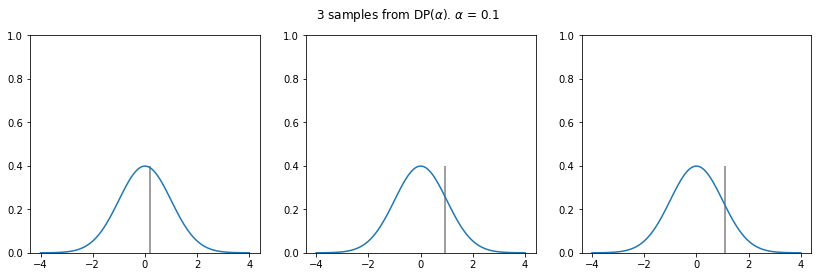

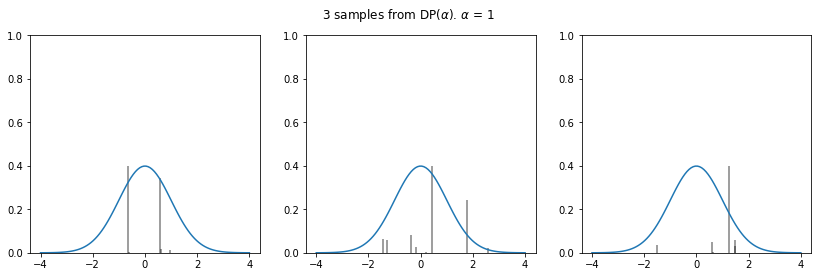

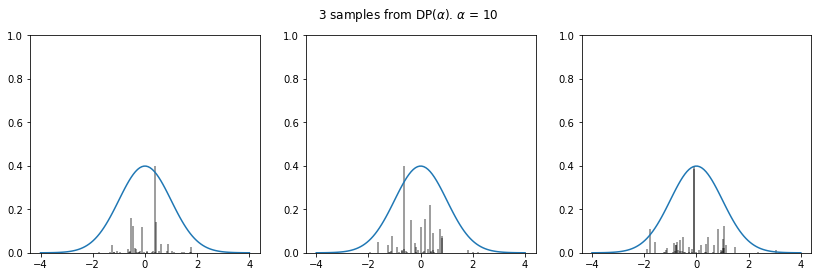

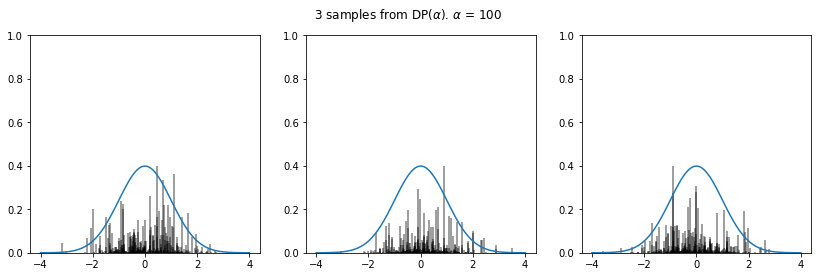

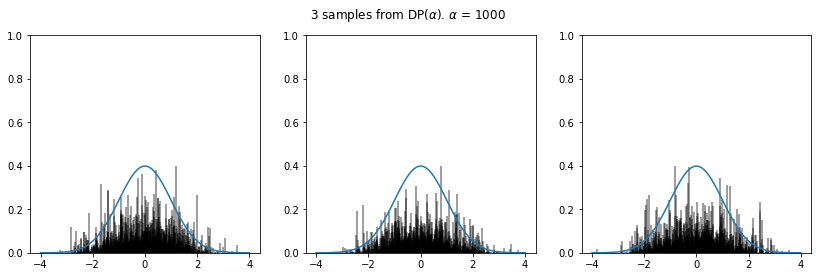

In [188]:
def dirichlet_process(h_0, alpha):
    """
    Truncated dirichlet process.
    :param h_0: (scipy distribution)
    :param alpha: (flt)
    :param n: (int) Truncate value.
    """
    n = max(int(5 * alpha + 2), 500)  # truncate the values. 
    pi = stats.beta(1, alpha).rvs(size=n)
    pi[1:] = pi[1:] * (1 - pi[:-1]).cumprod()  # stick breaking process
    theta = h_0(size=n)  # samples from original distribution
    return pi, theta
        
def plot_normal_dp_approximation(alpha, n=3):
    pi, theta = dirichlet_process(stats.norm.rvs, alpha)
    x = np.linspace(-4, 4, 100)
    
    plt.figure(figsize=(14, 4))
    plt.suptitle(r'{} samples from DP($\alpha$). $\alpha$ = {}'.format(n, alpha))
    plt.ylabel(r'$\pi$')
    plt.xlabel(r'$\theta$')
    pltcount = int('1' + str(n) + '0')
    
    for i in range(n):
        pltcount += 1
        plt.subplot(pltcount)
        pi, theta = dirichlet_process(stats.norm.rvs, alpha)
        pi = pi * (stats.norm.pdf(0) / pi.max())
        plt.vlines(theta, 0, pi, alpha=0.5)
        plt.ylim(0, 1)
        plt.plot(x, stats.norm.pdf(x))

np.random.seed(65)
for alpha in [.1, 1, 10, 100, 1000]:
    plot_normal_dp_approximation(alpha)
        

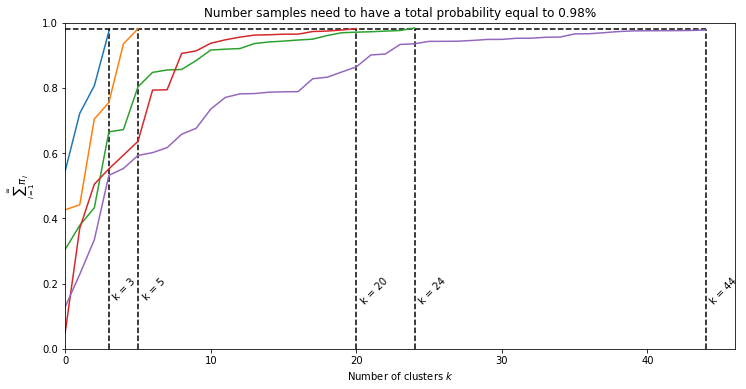

In [195]:
np.random.seed(95)

acceptance_p = 0.98
plt.figure(figsize=(12, 6))
plt.title(f'Number samples need to have a total probability equal to {acceptance_p}%')
plt.ylabel('$\sum_{i=1}^{\infty}{\pi_i}$')
plt.xlabel('Number of clusters $k$')
def plot_summation(alpha):
    pi, _ = dirichlet_process(stats.norm.rvs, alpha)
    p_total = np.cumsum(pi)
    i = np.argmin(np.abs(p_total - acceptance_p))
    plt.plot(np.arange(pi[:i + 1].shape[0]), p_total[:i + 1])
    return i

k = 0
for alpha in [1, 2, 5, 7, 10]:
    k_i = plot_summation(alpha)
    k = max(k, k_i)
    plt.vlines(k_i, 0, acceptance_p, linestyles='--')
    plt.text(k_i + 0.2, 0.2, f'k = {k_i}', rotation=45)
    
plt.ylim(0, 1)
plt.xlim(0, k + 2)
plt.hlines(acceptance_p, 0, k, linestyles='--')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


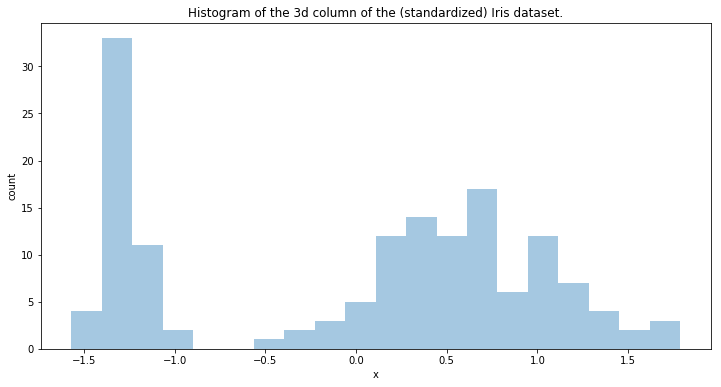

In [4]:
plt.figure(figsize=(12, 6))
plt.title('Histogram of the 3d column of the (standardized) Iris dataset.')
plt.xlabel('x')
plt.ylabel('count')
sns.distplot(y[:, 2], bins=20, kde=None)

In [5]:
import pymc3 as pm
from theano import tensor as tt

In [6]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

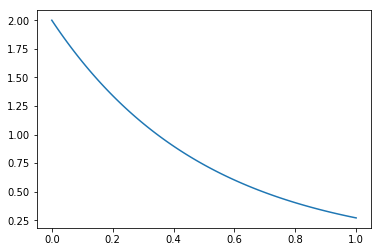

In [15]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.gamma(1, 0, 0.5).pdf(x))

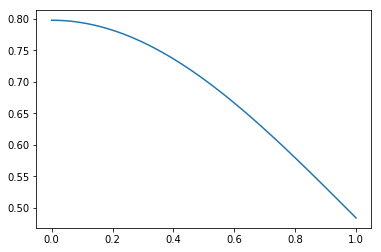

In [16]:
plt.plot(x, stats.halfnorm(0, 1).pdf(x))

In [27]:
stats.gamma(1, 0, 1).rvs(1000).mean()

1.0295230814623677

In [ ]:
k = 35
m = pm.Model()
with m:
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=k)
    pi = pm.Deterministic('pi', stick_breaking(beta))

    sd = pm.HalfNormal('sd', 1, shape=k)    
    lambda_1 = pm.Uniform('lambda1', 0, 10, shape=k)
    mu_0 = pm.Normal('mu_0', 0, 1)
    
    mu = pm.Normal('mu', mu=mu_0, sd=lambda_1 * sd, shape=k)
    obs = pm.NormalMixture('obs', w=pi, mu=mu, sd=lambda_ * sd, observed=y[:, 2])

In [244]:
k = 35
m = pm.Model()
with m:
    alpha = pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=k)
    pi = pm.Deterministic('pi', stick_breaking(beta))

    tau = pm.Gamma('tau', 1, 1, shape=k)    
    lambda_ = pm.Uniform('lambda', 0, 1, shape=k)
    mu0 = pm.Uniform('mu0', -3, 3, shape=k)
    
    mu = pm.Normal('mu', mu=mu0, tau=1, shape=k)
    obs = pm.NormalMixture('obs', w=pi, mu=mu, tau=lambda_ * tau, observed=y[:, 2])

In [82]:
for RV in m.basic_RVs:
    print(RV.name, RV.logp(m.test_point))

alpha_log__ -1.0
beta_logodds__ -48.52030263919613
tau_log__ -35.0
lambda1_interval__ -48.52030263919613
lambda2 -56.42299998176168
mu -16.127760854365846
obs -256.61897509450506


In [245]:
with m: 
    step = None
    trace = pm.sample(500, tune=500, init='advi', random_seed=35171, step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 265.37:   8%|▊         | 15305/200000 [00:13<02:46, 1106.63it/s]
Convergence archived at 15400
Interrupted at 15,399 [7%]: Average Loss = 275.51
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu0_interval__, lambda_interval__, tau_log__, beta_logodds__, alpha_log__]
100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8832672993179058, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9412707023823474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not mat

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2046b33048>,
      dtype=object)

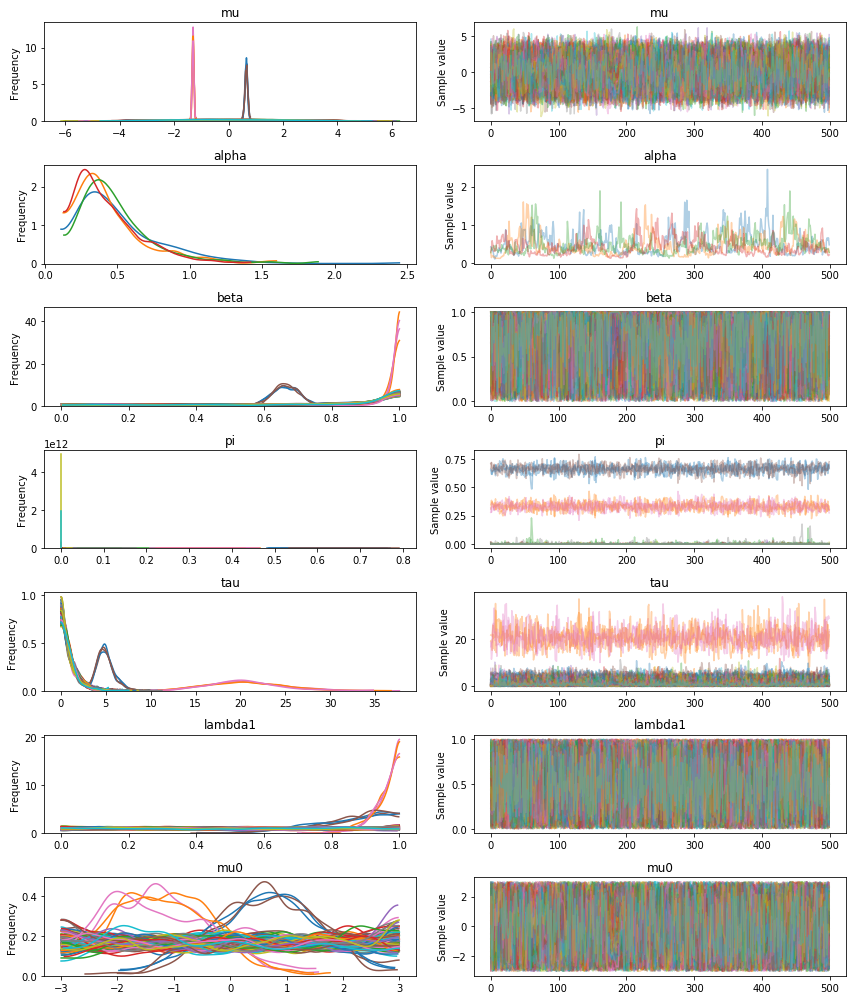

In [120]:
pm.traceplot(trace)

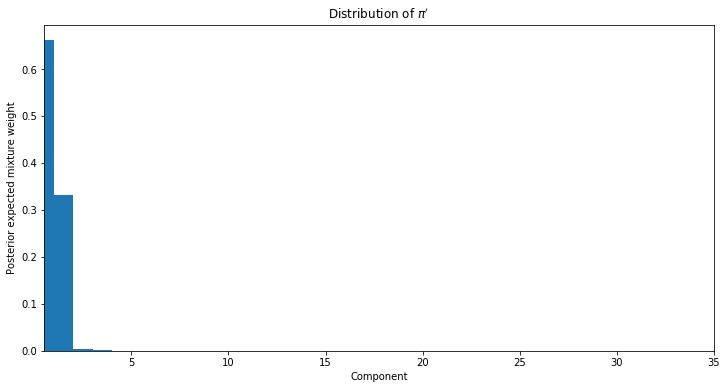

In [179]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of $\pi'$")
plt.bar(np.arange(k) + 1 - 0.5, trace['pi'].mean(axis=0), width=1., lw=0);
plt.xlim(0.5, k);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

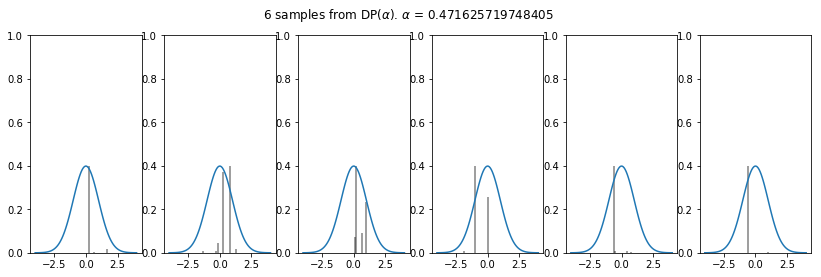

In [189]:
plot_normal_dp_approximation(trace['alpha'].mean(), 6)

In [210]:
p[0]

array([ 0.64885315, -1.30709587,  0.02895939, -0.04105907, -0.08588051,
       -0.08249138, -0.13069356, -0.06956456, -0.11705567, -0.28732056,
       -0.14913065, -0.09560382, -0.17197101, -0.18029005, -0.13289487,
       -0.0966986 , -0.14822977, -0.15511884, -0.01362059, -0.08300809,
       -0.12929974, -0.16073243, -0.16999157, -0.19414815, -0.12453189,
       -0.15904975, -0.10099628, -0.0359372 , -0.14126203, -0.18965758,
       -0.19326695, -0.11220963, -0.10462724, -0.2159177 , -0.19433511])

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


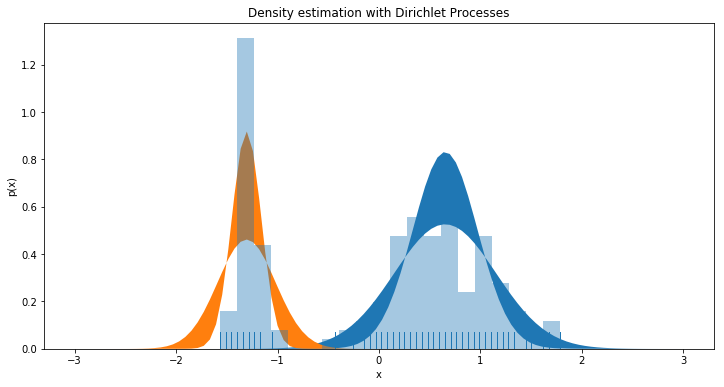

In [243]:
plt.figure(figsize=(12, 6))
plt.title('Density estimation with Dirichlet Processes')
plt.xlabel('x')
plt.ylabel('p(x)')
x = np.linspace(-3,  3, 100)
pi_mean = trace['pi'].mean(0)
mu_mean = trace['mu'].mean(0) 
mu0_mean = trace['mu0'].mean(0)
lambda_mean = trace['lambda1'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_mean))
tau_sd = trace['mu'].std(0)
lambda_sd = trace['lambda1'].std(0)
sd_sd = np.sqrt((1 / tau_sd * lambda_sd))

p = stats.norm.interval(0.05, trace['mu'].mean(0), trace['mu'].std(0))
psd = stats.norm.interval(0.05, sd_mean, sd_std)

a = 2
plt.fill_between(x, stats.norm.pdf(x, mu_mean[0], psd[0][0]) * pi_mean[0], stats.norm.pdf(x, mu_mean[0], psd[1][0]) * pi_mean[0])
plt.fill_between(x, stats.norm.pdf(x, mu_mean[1], psd[0][1]) * pi_mean[1], stats.norm.pdf(x, mu_mean[1], psd[1][1]) * pi_mean[1])
sns.distplot(y[:, 2], bins=20, kde=None, norm_hist=True, rug=True, )

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


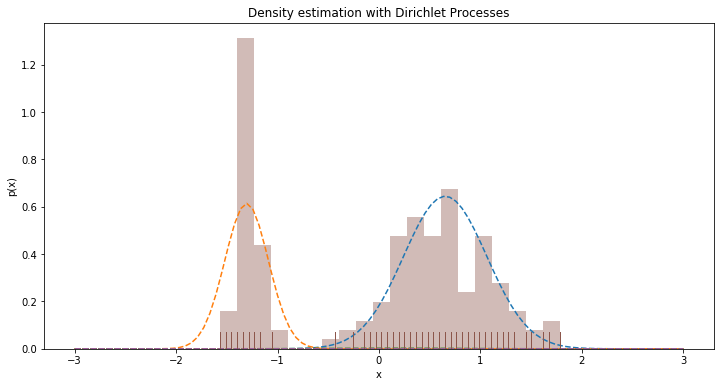

In [167]:
plt.figure(figsize=(12, 6))
plt.title('Density estimation with Dirichlet Processes')
plt.xlabel('x')
plt.ylabel('p(x)')
x = np.linspace(-3,  3, 100)
pi_mean = trace['pi'].mean(0)
mu_mean = trace['mu'].mean(0) 
mu0_mean = trace['mu0'].mean(0)
lambda_1_mean = trace['lambda1'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_1_mean))

plt.plot(x, stats.norm.pdf(np.repeat(x[:, None], k, axis=1), 
                           loc=mu_mean, 
                           scale=sd_mean) * pi_mean,
        ls='--')
sns.distplot(y[:, 2], bins=20, kde=None, norm_hist=True, rug=True, )
plt.show()